# Applied Machine Learning, Week 1 Exercises.
## Regularization examples with varying lambda values
This notebook creates a small model and shows how it varies when using L1 and L2 regularization. It also shows how changing the value of the `lambda` (λ) parameter in L1 and L2 regularization shrink the model coefficients and reduce the changes of overfitting the model.

This code is modified from the excellent [example](https://github.com/luisguiserrano/manning/tree/master/Chapter_04_Testing_Overfitting_Underfitting) in Chapter 4 of Luis Serrano's [_Grokking Machine Learning_](https://www.manning.com/books/grokking-machine-learning). The major difference is some additional examples at the end that show how lasso and ridge regression change with different lambda values.

In [23]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import utils

# set the random seed to 0 to make the result reproducible
# uncomment this or change the seed to see different results
random.seed(0)

### Defining the dataset
We'll create a set of random data points close to an inverted parabola ($y = -x^2+2$). First, generate the parabola and plot it.

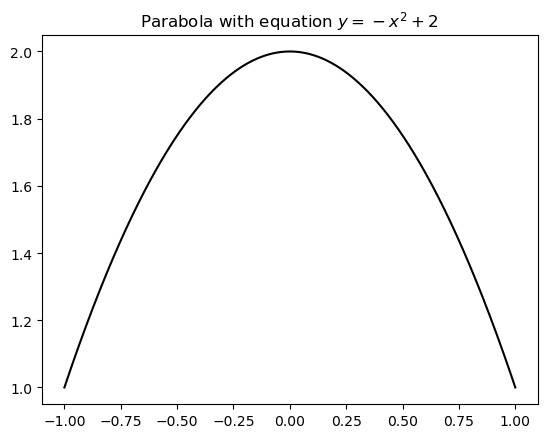

In [24]:
# Our original polynomial is -x^2+2, so the coefficient list = [2, 0, -1]
# (the 0th coefficient is the 0th in the array, the 1st is the 1st...)
coefs = [2, 0,  -1]

def polynomial(coefs, x):
    """
    Given an x value and a set of coefficients, return the y value for the polynomial.

    Args:
        coefs: a list of coefficients
        x: the x value in the polynomial

    Returns:
        the sum (y) of multiplying each coefficient by x
    """
    n = len(coefs)
    return sum([coefs[i]*x**i for i in range(n)])

def draw_polynomial(coefs, linestyle="-", label=""):
    """
        Draw a polynomial with the set of coefficients

        Args:
            a set of polynomial coefficients
    """
    n = len(coefs)
    x = np.linspace(-1, 1, 1000)
    #plt.ylim(0,3)
    plt.title(r"Parabola with equation $y = -x^2+2$ ")
    plt.plot(x, sum([coefs[i]*x**i for i in range(n)]), linestyle=linestyle, color='black', label=label)

draw_polynomial(coefs)

In [25]:
# A little syntactic sugar. Make a function called inverted_parabola that 
# calls polynomial with our coefficients and an argument of x
inverted_parabola = lambda x: polynomial(coefs,x)

# calling inverted parabola with x=3 should give the y value of 7 (-3^2 + 2)
assert inverted_parabola(3) == -7

Generating a dataset of 40 points that lie close to this polynomial.

In [26]:
# X and Y will contain the (x,y) points for the data
X = []
Y = []

# generate 40 data points
for i in range(40):

    # pick a random x point
    x = random.uniform(-1,1)

    # use the x point to generate the y point and throw in randomness in to vary its value
    y = inverted_parabola(x) + random.gauss(0,0.1)
    X.append(x)
    Y.append(y)

### Plot the generated data against the "ideal" inverted parabola.

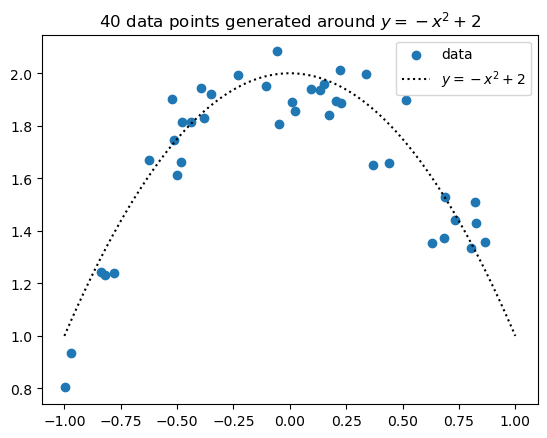

In [27]:
plt.scatter(X, Y, label="data")
draw_polynomial(coefs, label=r'$y = -x^2+2$', linestyle="dotted" )
plt.title(r"40 data points generated around $y = -x^2+2$")
plt.legend()
plt.show()

### Training a polynomial regression model

First, define a function to train a model with 1) linear regression, 2) lasso regression, or 3) ridge regression.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def train_polynomial_regression(X, Y, degree, regularization=None, alpha=1.0):
    """
    Trains a polynomial regression model with optional L1 or L2 regularization.

    Args:
      X: Input features (list or numpy array).
      Y: Input labels (list or numpy array).
      degree: The degree of the polynomial.
      regularization: Type of regularization ('l1', 'l2', or None). Defaults to None.
      alpha: Regularization strength (for L1 and L2). Defaults to 1.0.

    Returns:
      A trained scikit-learn model object (LinearRegression, Ridge, or Lasso).
    """
    X = np.array(X).reshape(-1, 1)
    Y = np.array(Y)

    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    if regularization == 'L1':
        model = Lasso(alpha=alpha)
    elif regularization == 'L2':
        model = Ridge(alpha=alpha)
    else:
        model = LinearRegression()

    model.fit(X_poly, Y)

    return model

Now call the function with the parameter `degrees_used`, a variable that contains the number of coefficents for the model. The example below sets `degrees_used = 10`, making it a polynomial with degree 10. This leads to overfitting (see the resulting plot).

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniconda/base/envs/datascience/lib/python3.12/site-packages/matplotlib/pyplot.py'>

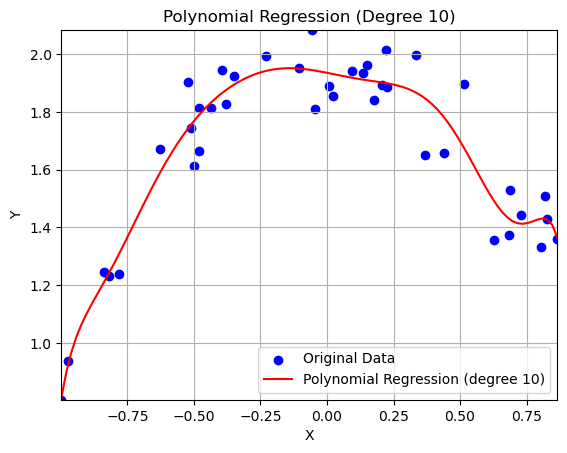

In [29]:
degree_used = 10
model = train_polynomial_regression(X, Y, degree_used)

# plot the polynomial 
utils.plot_polynomial_regression(model, X, Y, degree_used)

## Splitting data into training and testing
Split the dataset into training and test sets.

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print("Shape of X_train:", np.shape(X_train))
print("Shape of X_test:", np.shape(X_test))
print("Shape of Y_train:", np.shape(Y_train))
print("Shape of Y_test:", np.shape(Y_test))

Shape of X_train: (32,)
Shape of X_test: (8,)
Shape of Y_train: (32,)
Shape of Y_test: (8,)


### Training a polynomial regression model with no regularization
This is standard linear regression. Train the model with `degree_used` coefficients using the training sets, then look at what we get.

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniconda/base/envs/datascience/lib/python3.12/site-packages/matplotlib/pyplot.py'>

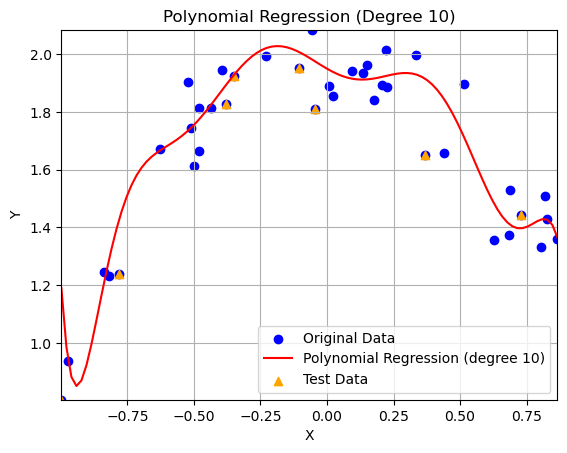

In [31]:
model_no_reg = train_polynomial_regression(X_train, Y_train, degree_used)
utils.plot_polynomial_regression(model_no_reg, X, Y, degree_used, X_test, Y_test)

### Calculate the root mean squared error (RMSE) using the function below.

In [32]:
from sklearn.metrics import mean_squared_error

def evaluate_model(model, X_test, Y_test, degree):
    """
    Evaluates a trained polynomial regression model on test data and returns the RMSE.

    Args:
      model: The trained LinearRegression model object.
      X_test: Test set features (list or numpy array).
      Y_test: Test set labels (list or numpy array).
      degree: The degree of the polynomial used for training.

    Returns:
      The Root Mean Squared Error (RMSE) on the test set.
    """
    X_test = np.array(X_test).reshape(-1, 1)
    Y_test = np.array(Y_test)

    poly = PolynomialFeatures(degree=degree)
    X_test_poly = poly.fit_transform(X_test)

    y_pred = model.predict(X_test_poly)

    rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

    return rmse

In [33]:
square_loss_no_reg = evaluate_model(model_no_reg, X_test, Y_test, degree_used)
print(f"Square loss on the test set (degree {degree_used}): {square_loss_no_reg}")

Square loss on the test set (degree 10): 0.18991444419271022


### Training a polynomial regression model with L1 regularization

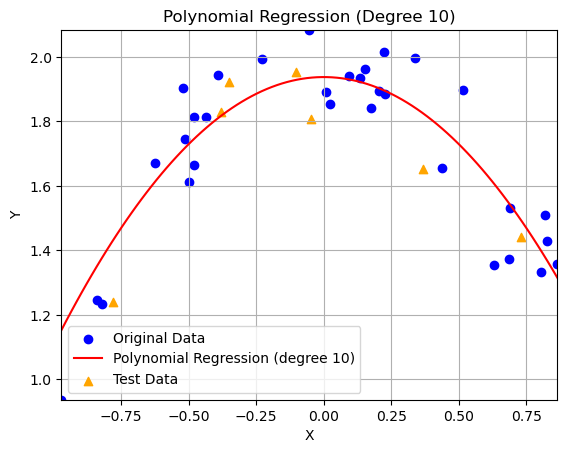

In [34]:
# set Lambda = 0.01
L1_lambda = 0.01

# Train with L1 (Lasso) regularization
model_L1_reg = train_polynomial_regression(X_train, Y_train, degree_used, 'L1', L1_lambda)
utils.plot_polynomial_regression(model_L1_reg, X_train, Y_train, degree_used, X_test, Y_test)
plt.show()

In [35]:
square_loss_L1_reg = evaluate_model(model_L1_reg, X_test, Y_test, degree_used)
print(f"Square loss on the test set (degree {degree_used}): {square_loss_L1_reg}")

Square loss on the test set (degree 10): 0.15277291798691608


### Training a polynomial regression model with L2 regularization

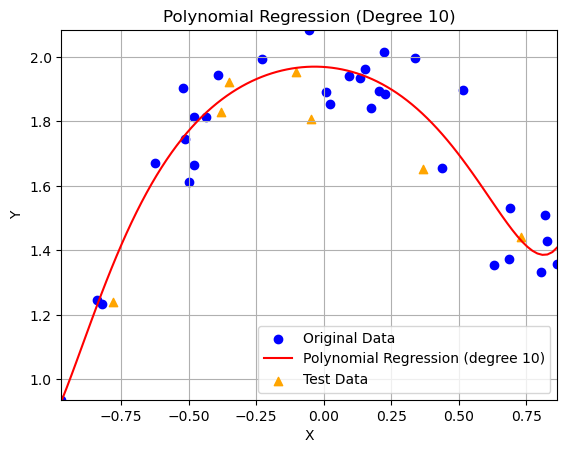

In [36]:
# set Lambda = 0.01
L2_lambda = 0.01

# Train with L2 (Ridge) regularization
model_L2_reg = train_polynomial_regression(X_train, Y_train, degree_used, 'L2', L2_lambda)
utils.plot_polynomial_regression(model_L2_reg, X_train, Y_train, degree_used, X_test, Y_test)
plt.show()

In [37]:
square_loss_L2_reg = evaluate_model(model_L2_reg, X_test, Y_test, degree_used)
print(f"Square loss on the test set (degree {degree_used}): {square_loss_L2_reg}")

Square loss on the test set (degree 10): 0.09796369954219714


### Exploring the model coefficents

Let's take a look at the coeeficients for each of the models: Linear, Lasso, and Ridge regression.   

We should see three things:
1. In the linear regression, all 10 of the model coeeficients have a non-zero value &mdash; all coefficients are included in the model.
2. In the lasso regression, we end up with fewer coefficients than the original 10. This is because lasso, L1, regularization transforms some of the coefficients to zero, making for a simpler model.
3. In the ridge regression, the 10 coefficients are likely still present but their values have been reduced. This tends to reduce some of the oscillations that can lead to overfitting.

In [38]:
print("Coefficients of the model with no regularization")
print(model_no_reg.coef_)
print()
print("Coefficients of the model with L1 regularization")
print(model_L1_reg.coef_)
print()
print("Coefficients of the model with L2 regularization")
print(model_L2_reg.coef_)

Coefficients of the model with no regularization
[  0.          -0.53042137   1.12584832   7.93478826 -14.61941154
 -36.79971847  35.25286399  61.81685685 -32.90067708 -33.61265487
   9.22285627]

Coefficients of the model with L1 regularization
[ 0.          0.         -0.83079676  0.         -0.          0.
 -0.          0.         -0.          0.         -0.        ]

Coefficients of the model with L2 regularization
[ 0.         -0.05575426 -0.82876633 -0.13856136 -0.483076    0.17481434
  0.09401402  0.30704696  0.30304178  0.22231002  0.33303744]


### What happens when lambda varies for L1 regularization?
The code below generates four plots using L1 regularization where lambda = 0.0, 0.01, 0.05, and 0.1. When lambda = 0, the model is a standard linear regression, so you'll see the overfitting. As lambda increases, you start to see the model behavior changing. The fit looks quite good when lambda = 0.01. The parabola gets flatter when lambda = 0.05, and it's essentially linear at lambda = 0.1. This shows the importance of testing various values for lambda.

If you look at the code, you'll see it doesn't use the `L1` parameter in `train_polynomial_regression` when `lambda = 0`. This is because scikit-learn's Lasso object doesn't like lambda = 0, and the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) tells us to use the LinearRegression object instead. That is because lambda=0 cancels out the regularization term, effectively making it a standard linear regression.

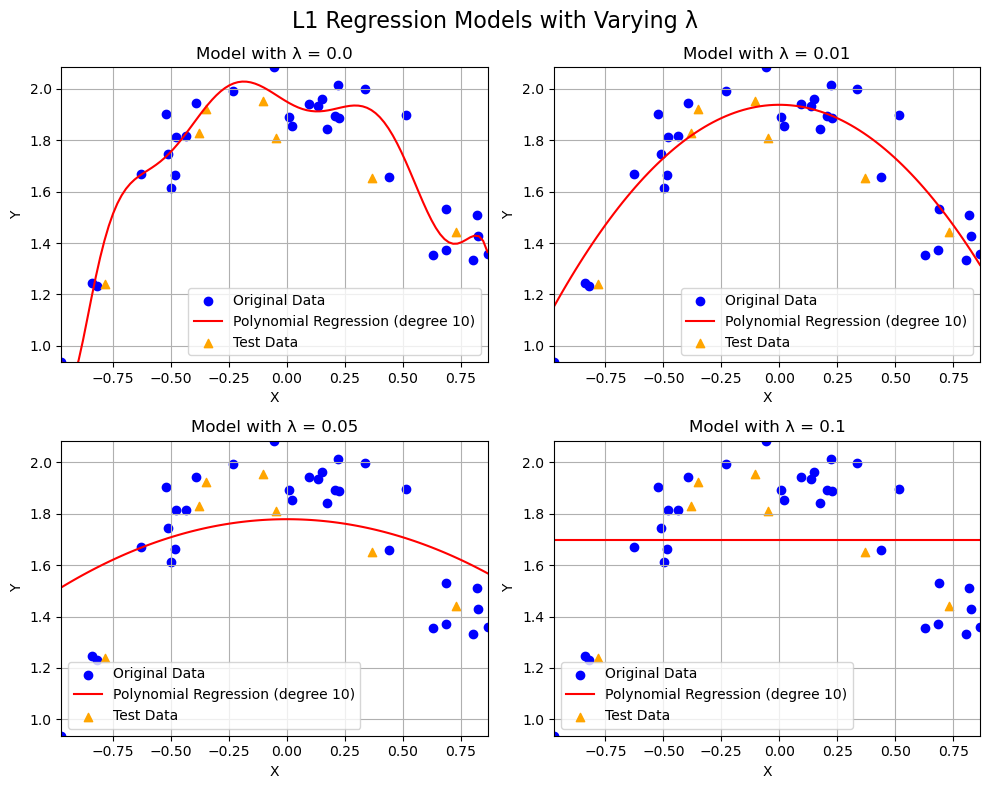

In [39]:
lambda_values = [0.00, 0.01, 0.05, 0.1]

# collect the models generated with different lambdas
L1_models = []

fig, axs = plt.subplots(2, 2, figsize=(10,8))

# flatten the axs array to simplify the iteration in the for loop 
axs = axs.flatten()

# plot each model with a different lambda value
for i, lam in enumerate(lambda_values):
    # Train with L1 (Lasso) regularization.
    # Setting lambda = 0 with scikit-learn Lasso object isn't advised. Instead, we call the LinearRegression model
    # since Lasso with λ = 0 is equivalent.
    if lam == 0:
        model_L1_reg = train_polynomial_regression(X_train, Y_train, degree_used, 'None') 
    else:
        model_L1_reg = train_polynomial_regression(X_train, Y_train, degree_used, 'L1', lam) 

    L1_models.append(model_L1_reg)

    # set the current axis for the plot    
    plt.sca(axs[i])
    utils.plot_polynomial_regression(model_L1_reg, X_train, Y_train, degree_used, X_test, Y_test)
    axs[i].set_title(f"Model with λ = {lam}")


fig.suptitle("L1 Regression Models with Varying λ", fontsize=16)
plt.tight_layout()
plt.show()

### Look at the coefficients as λ increases during L1 regularization
In L1 regularization, we should see the model coefficients getting smaller as lambda gets bigger. Even more characteristic of L1, some of the coefficients may disappear entirely.

In [40]:
for lambda_value, model in zip(lambda_values, L1_models):
    print(f"Coefficients of the model with L1 regularization and λ = {lambda_value}:")
    print(model.coef_, "\n")


Coefficients of the model with L1 regularization and λ = 0.0:
[  0.          -0.53042137   1.12584832   7.93478826 -14.61941154
 -36.79971847  35.25286399  61.81685685 -32.90067708 -33.61265487
   9.22285627] 

Coefficients of the model with L1 regularization and λ = 0.01:
[ 0.          0.         -0.83079676  0.         -0.          0.
 -0.          0.         -0.          0.         -0.        ] 

Coefficients of the model with L1 regularization and λ = 0.05:
[ 0.          0.         -0.28042715  0.         -0.          0.
 -0.          0.         -0.          0.         -0.        ] 

Coefficients of the model with L1 regularization and λ = 0.1:
[ 0.  0. -0.  0. -0.  0. -0.  0. -0.  0. -0.] 



### What happens when lambda varies for L2 regularization?
The code below generates four plots where lambda = 0.0, 0.01, 0.1, and 1.0. When lambda = 0, the model is a standard linear regression, so you'll see the overfitting. As lambda increases, you start to see the model results changing.


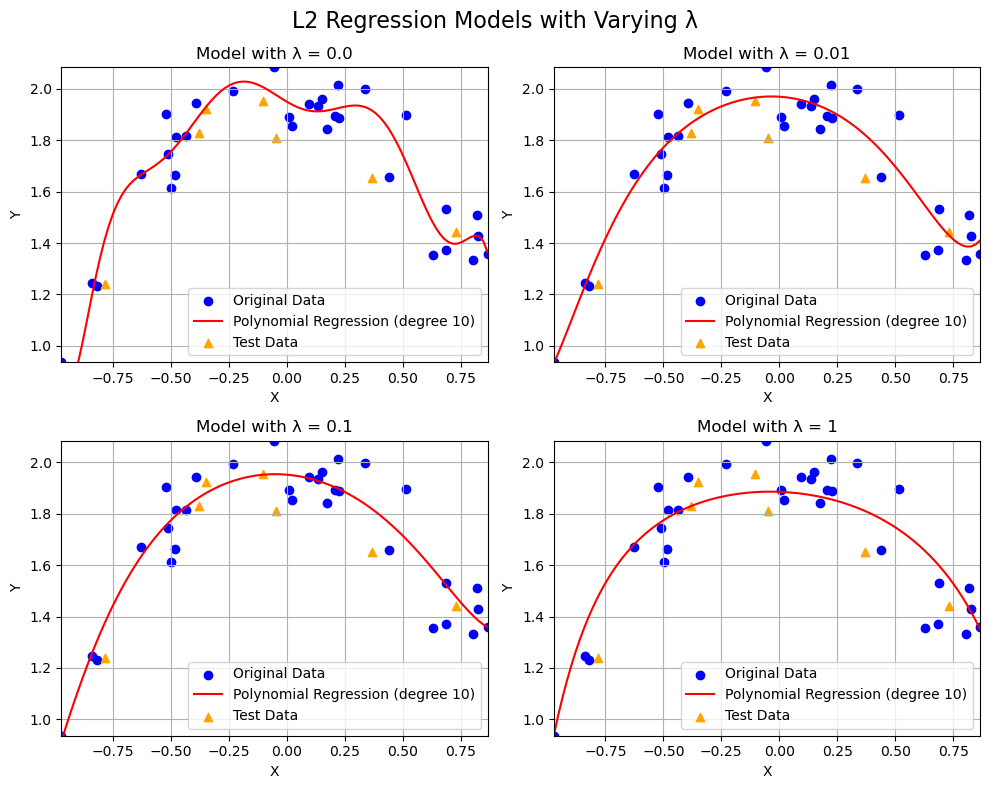

In [41]:
lambda_values = [0.0, 0.01, 0.1, 1]

# collect the models generated with different lambdas
L2_models = []

# set up the visualization for 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10,8))

# flatten the axs array to simplify the iteration in the for loop 
axs = axs.flatten()

# plot each model with a different lambda value
for i, lam in enumerate(lambda_values):
    # Train with L2 (Ridge) regularization
    model_L2_reg = train_polynomial_regression(X_train, Y_train, degree_used, 'L2', lam)

    L2_models.append(model_L2_reg)

    # set the current axis for the plot    
    plt.sca(axs[i])
    
    # plot the model, training daya, and test data
    utils.plot_polynomial_regression(model_L2_reg, X_train, Y_train, degree_used, X_test, Y_test)

    # set the subplot title
    axs[i].set_title(f"Model with λ = {lam}")


fig.suptitle("L2 Regression Models with Varying λ", fontsize=16)
plt.tight_layout()
plt.show()

### Look at the coefficients as λ increases during L2 regularization
In L2 regularization, we should also see the model coefficients getting smaller as lambda gets bigger. Unlike L1 regularization, i'ts unlikely that we'll see coefficients reduced completely to zero.

In [42]:
for lambda_value, model in zip(lambda_values, L2_models):
    print(f"Coefficients of the model with L2 regularization and λ = {lambda_value}:")
    print(model.coef_, "\n")


Coefficients of the model with L2 regularization and λ = 0.0:
[  0.          -0.53042137   1.12584832   7.93478826 -14.61941154
 -36.79971847  35.25286399  61.81685685 -32.90067708 -33.61265487
   9.22285627] 

Coefficients of the model with L2 regularization and λ = 0.01:
[ 0.         -0.05575426 -0.82876633 -0.13856136 -0.483076    0.17481434
  0.09401402  0.30704696  0.30304178  0.22231002  0.33303744] 

Coefficients of the model with L2 regularization and λ = 0.1:
[ 0.         -0.07624435 -0.75910316  0.02687459 -0.28330698  0.1220943
 -0.01728653  0.12660094  0.0944964   0.08686748  0.13505521] 

Coefficients of the model with L2 regularization and λ = 1:
[ 0.         -0.0335379  -0.42357259  0.01223651 -0.25094492  0.04221152
 -0.14617492  0.04661823 -0.08842876  0.04086458 -0.05557688] 

